<a href="https://colab.research.google.com/github/Yango4you/FP_TUM/blob/main/DeepMetricLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#import tensorflow_addons to use the 'TripletSemiHardLoss' 
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 3.1 MB/s 


##Prepare: CIFAR-10 as the dataset

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170508288/170498071 [==============================] - 2s 0us/step


###Ploting the training set 

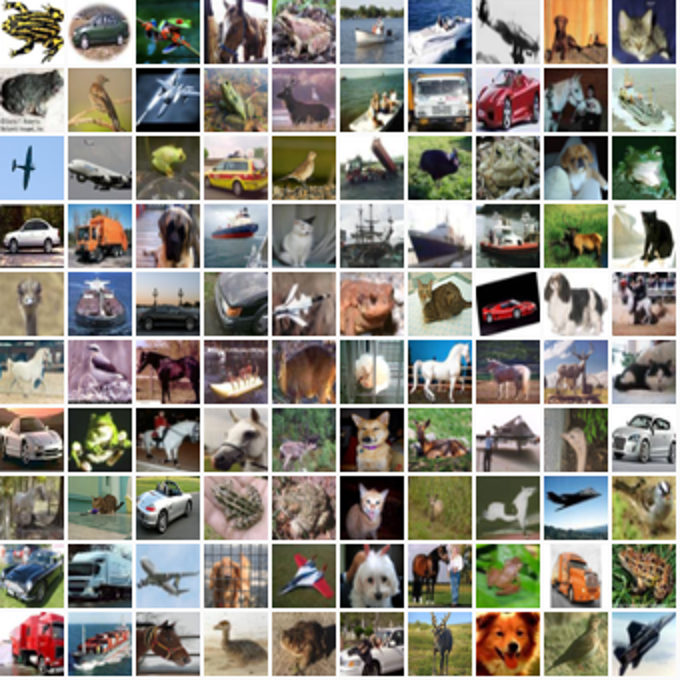

In [ ]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Show a collage of 10x10 random images.
sample_idxs = np.random.randint(0, 50000, size=(10, 10))
examples = x_train[sample_idxs]
show_collage(examples)

In [ ]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

##Sample: Building the anchor, negative and positive paar together

In [ ]:
num_classes = 10


class AnchorPositiveNegativePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((3, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            negative_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx or negative_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
                negative_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
            x[2, class_idx] = x_train[negative_idx]
        
        return x
    
    #def on_epoch_end(self):
        

###Plotting the first batch

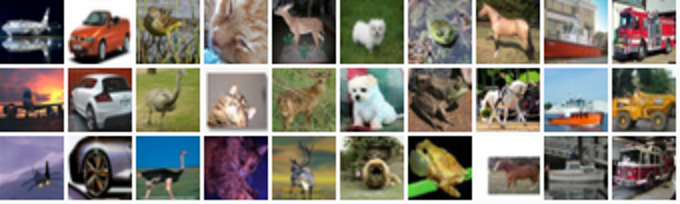

In [ ]:
examples = next(iter(AnchorPositiveNegativePairs(num_batchs=11)))

show_collage(examples)

##Loss-function:Building the embedding model

In [ ]:
#Custom Model
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives, negatives = data[0], data[1], data[2]
        vio_margin = 0.2
        h = keras.losses.Hinge()

        with tf.GradientTape() as tape:
            # Run anchors negatives and positives through model.
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)
            negative_embeddings = self(negatives,training=True)

            loss_triplet = (anchor_embeddings-positive_embeddings)**2- (anchor_embeddings-negative_embeddings)**2 + vio_margin
            loss_hinge = 0.5* h(loss_triplet)
            loss = self.compiled_loss(loss_hinge)


        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

##Traning the model

Epoch 1/20
1000/1000 [==============================] - 15s 13ms/step - loss: 2.2357
Epoch 2/20
1000/1000 [==============================] - 14s 14ms/step - loss: 2.1257
Epoch 3/20
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0414
Epoch 4/20
1000/1000 [==============================] - 13s 13ms/step - loss: 2.0064
Epoch 5/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9738
Epoch 6/20
1000/1000 [==============================] - 21s 21ms/step - loss: 1.9443
Epoch 7/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.9102
Epoch 8/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8775
Epoch 9/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8585
Epoch 10/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8299
Epoch 11/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8040
Epoch 12/20
1000/1000 [==============================] - 14s 14

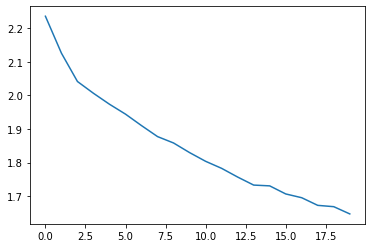

In [ ]:
inputs = layers.Input(shape=(height_width, height_width, 3))

size_kernel = 3
stride = 2

x = layers.Conv2D(filters=32, kernel_size=size_kernel, strides=stride, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=size_kernel, strides=stride, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=size_kernel, strides=stride, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.GlobalMaxPooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss = tfa.losses.TripletSemiHardLoss()
    #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)

plt.plot(history.history["loss"])
plt.show()

##Testing

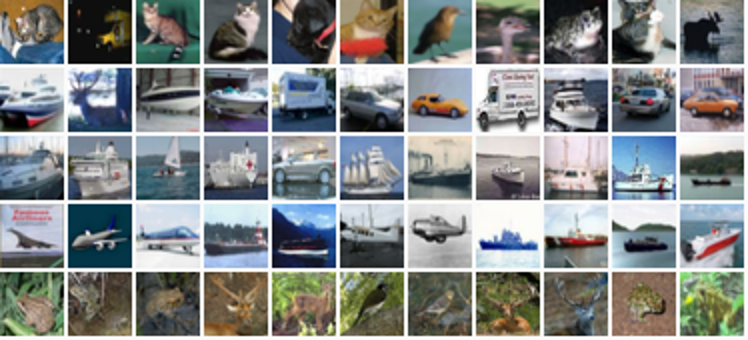

In [ ]:
near_neighbours_per_example = 10

embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

###Confusion Matrix

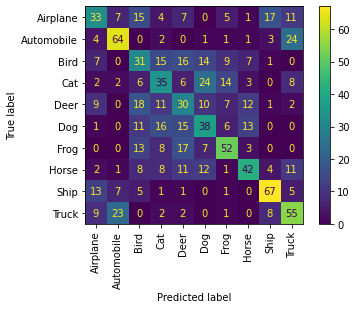

In [ ]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

In [ ]:
#Custom Model
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives, negatives = data[0], data[1], data[2]
        vio_margin = 0.3
        h = keras.losses.Hinge()

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)
 
            
            
            # Calculate cosine similarity between anchors and positives.
            similarities = tf.einsum("ik,jk->ij", anchor_embeddings, positive_embeddings)

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.2
            similarities /= temperature

            # Using similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)


        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}